<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:45px;">
  <div style="color:#993520; font-size:54px; font-weight:bold; margin-bottom:10px;">
    SENTIMENT ANALYSIS OF U.S. SENATORS' TWEETS
  </div>
  <div style="color:#333; font-size:22px; margin-top:10px;">
    Transformers-based sentiment pipeline + political communication insights (May–Oct 2020)
      </div>
    Performed by: Zahra Eshtiaghi 476679 Under Supervision of Dr. Maciej Świtała
  </div>
</div>



### 1. Intro

**Scientific relevance.** Political communication on social media is a key research area in computational social science. Tweets are short, informal, and often contain entities, hashtags, and links—making them a good test case for domain-specific NLP.

**Business relevance.** Sentiment tracking supports media monitoring, public-relations risk detection, campaign messaging analysis, and stakeholder communication.

**Project objective (clear & measurable).**
Build an end-to-end sentiment analysis pipeline using **Transformer models** to:
1) label each tweet as **Negative / Neutral / Positive**,
2) quantify sentiment over time and by party/state,
3) study the relationship between sentiment and engagement (likes/retweets/replies),
4) provide validated, interpretable conclusions.

**Research questions.**
- RQ1: How does sentiment distribution differ by party?
- RQ2: Does sentiment shift over time (monthly trend, key periods)?
- RQ3: Are more positive/negative tweets associated with higher engagement?
- RQ4: Which senators (accounts) have the most positive vs most negative average sentiment?
- RQ5: Does model confidence change by party or by sentiment class?

In [ ]:
# !pip -q install pandas numpy matplotlib tqdm transformers torch scikit-learn

### 3. Setup


In [3]:
# (run once)
# !pip -q install pandas numpy matplotlib tqdm transformers torch scikit-learn

import re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification

plt.rcParams['figure.dpi'] = 120


/Users/majid/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4. Load and audit the dataset


In [ ]:
DATA_PATH = "/Users/majid/Documents/3-third semester/text mining /project/senator sentiment/senator_twitter_May-Oct.csv"

df = pd.read_csv(DATA_PATH)
# drop index-like columns
df = df.drop(columns=[c for c in df.columns if c.lower().startswith('unnamed')], errors='ignore')

# parse time
# (tweet timestamps are treated as UTC here; adjust if you have timezone info)
df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)

print('Shape:', df.shape)
display(df.head(3))
print('Columns:', df.columns.tolist())

# missingness audit
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(10))


Shape: (30490, 15)


,tweet_id,time,text,replies,retweets,likes,from_user,from_content,twitter_id,name,state,party,gender,birth,age
0,1322145371108331520,2020-10-30 11:56:35+00:00,More jobs. More investment. More economic oppo...,40,24,143,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
1,1321926867696390144,2020-10-29 21:28:20+00:00,Marty and I are excited to be back on the camp...,46,26,107,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
2,1321906471244845061,2020-10-29 20:07:17+00:00,ICYMI: Gov. Kemp announces 46 people snared in...,24,30,174,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57


Columns: ['tweet_id', 'time', 'text', 'replies', 'retweets', 'likes', 'from_user', 'from_content', 'twitter_id', 'name', 'state', 'party', 'gender', 'birth', 'age']


birth           1.000000
from_content    0.912693
from_user       0.912332
text            0.004264
tweet_id        0.000000
time            0.000000
replies         0.000000
retweets        0.000000
likes           0.000000
twitter_id      0.000000
dtype: float64

### 5. Cleaning & preprocessing
Cleaning steps:
- dropping “Unnamed” index columns
- parsing time to datetime
- dropping missing text rows
- enforcing numeric types for likes/retweets/replies
- dropping fully-missing columns (your birth column is entirely missing)
- tweet normalization: @user + http replacements (recommended) 
- Dataloop
- creating analysis-ready features: month, log engagement (log1p), sentiment score

In [5]:
# 1) Remove rows with missing text
before = len(df)
df = df.dropna(subset=['text']).copy()
print('Dropped missing text:', before - len(df))

# 2) Ensure engagement columns are numeric
for col in ['likes','retweets','replies']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# 3) Drop columns that are entirely missing / not useful for analysis
# 'birth' is fully missing in this dataset
if 'birth' in df.columns and df['birth'].isna().all():
    df = df.drop(columns=['birth'])

# 4) Model-recommended tweet preprocessing: @mentions -> @user, URLs -> http
#    (keeps hashtags and text as-is)

def preprocess_tweet(text: str) -> str:
    text = str(text)
    new_tokens = []
    for t in text.split():
        if t.startswith('@') and len(t) > 1:
            t = '@user'
        elif t.startswith('http'):
            t = 'http'
        new_tokens.append(t)
    return ' '.join(new_tokens)

# extra cleanup: normalize whitespace

def normalize_whitespace(text: str) -> str:
    return re.sub(r'\s+', ' ', str(text)).strip()

# Apply

df['text_clean'] = df['text'].map(preprocess_tweet).map(normalize_whitespace)

# Feature engineering

df['date'] = df['time'].dt.date
# monthly bucket for trends

df['month'] = df['time'].dt.to_period('M').astype(str)

print('Final shape:', df.shape)


Dropped missing text: 130
Final shape: (30360, 17)


/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_3687/1865607092.py:43: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['time'].dt.to_period('M').astype(str)


### 6. Transformer sentiment model (batched inference)


In this part, I used a **Transformer-based sentiment model** to automatically classify each tweet as **Negative, Neutral, or Positive**. Instead of training a model from scratch (which would require a labeled dataset), I used a **pre-trained model** that is already optimized for tweets.

**Model choice**
I used the model `cardiffnlp/twitter-roberta-base-sentiment-latest`. This is a RoBERTa model that was trained on Twitter-like text and then fine-tuned for sentiment analysis. This is important because tweets contain short informal language, hashtags, mentions, and links, so a tweet-specific model usually performs better than a general sentiment model.

**How predictions were produced**
To predict sentiment for thousands of tweets efficiently, I did **batched inference**:

1. **Tokenization (text → numbers)**
   Transformers cannot read raw text directly. So I used a tokenizer that converts each tweet into tokens and numerical IDs.

   * `padding=True` ensures all tweets in a batch have equal length
   * `truncation=True` cuts off very long tweets to a maximum length (I used `max_length=128`)
     This helps keep the model fast and consistent.

2. **Running the model**
   After tokenizing a batch, I passed it through the Transformer model.
   The model outputs **logits**, which are raw scores for the three sentiment classes.

3. **Converting logits to probabilities**
   I applied `softmax` to convert logits into probabilities that sum to 1.
   This gives:

   * `p_neg`: probability tweet is negative
   * `p_neu`: probability tweet is neutral
   * `p_pos`: probability tweet is positive

4. **Choosing the final label + confidence**
   I selected the label with the highest probability using `argmax`.
   I also saved a confidence score (`sent_conf`), which is the probability of the predicted label.
   This is helpful later because low-confidence predictions are more uncertain.

**Why I used batching**

If I predicted one tweet at a time, it would be very slow. Batching allows the model to process many tweets at once, which is much faster and uses the GPU (if available). The loop runs through the dataset in chunks (e.g., 32 tweets per batch).

**Extra sentiment score for analysis**
Besides the label, I created numeric scores so I can calculate averages and trends:

* `sent_score`: Negative = −1, Neutral = 0, Positive = +1
* `sent_score_prob`: a smoother score computed as `p_pos − p_neg`
  This value is between −1 and +1 and is useful for comparing sentiment across groups (party/state) and over time.

As a result, each tweet now has both a sentiment class and probability values, which makes the later analysis more reliable and interpretable.




In [6]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

id2label = model.config.id2label
print('Labels:', id2label)


Device: cpu


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Labels: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [44]:
@torch.no_grad()
def predict_sentiment_batched(texts, batch_size=32, max_length=128):
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_length,
        ).to(device)

        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)

    probs = np.vstack(all_probs)
    pred_ids = probs.argmax(axis=1)
    labels = [id2label[int(i)] for i in pred_ids]
    conf = probs[np.arange(len(probs)), pred_ids]
    return probs, labels, conf

probs, labels, conf = predict_sentiment_batched(df['text_clean'].tolist(), batch_size=32)

# df['sent_label'] = labels
# df['sent_conf'] = conf
# # probabilities in model label order

# df['p_neg'] = probs[:, 0]
# df['p_neu'] = probs[:, 1]
# df['p_pos'] = probs[:, 2]

# # numeric scores for averaging
# label_to_score = {'Negative': -1, 'Neutral': 0, 'Positive': 1}

# df['sent_score'] = df['sent_label'].map(label_to_score).astype(int)
# # smooth score in [-1, 1]

# df['sent_score_prob'] = df['p_pos'] - df['p_neg']

# display(df[['time','name','party','state','text','sent_label','sent_conf']].head(5))
# 1) normalize labels
# df["sent_label"] = (
#     df["sent_label"]
#       .astype(str)
#       .str.strip()
#       .str.capitalize()
# )

# # 2) map safely
# label_to_score = {"Negative": -1, "Neutral": 0, "Positive": 1}
# df["sent_score"] = df["sent_label"].map(label_to_score)

# # 3) check what didn't map (important!)
# bad = df[df["sent_score"].isna()]["sent_label"].value_counts()
# print("Unmapped labels:\n", bad)

# # 4) use pandas nullable int type so NA doesn't crash
# df["sent_score"] = df["sent_score"].astype("Int64")  # not plain int


100%|██████████| 949/949 [14:22<00:00,  1.10it/s]


In [17]:
df["sent_label"] = (
    df["sent_label"]
      .astype(str)
      .str.strip()
      .str.capitalize()
)

# 2) map safely
label_to_score = {"Negative": -1, "Neutral": 0, "Positive": 1}
df["sent_score"] = df["sent_label"].map(label_to_score)

# 3) check what didn't map (important!)
bad = df[df["sent_score"].isna()]["sent_label"].value_counts()
print("Unmapped labels:\n", bad)

# 4) use pandas nullable int type so NA doesn't crash
df["sent_score"] = df["sent_score"].astype("Int64")  # not plain int

Unmapped labels:
 Series([], Name: count, dtype: int64)


In [30]:
df["p_neg"] = probs[:, 0]
df["p_neu"] = probs[:, 1]
df["p_pos"] = probs[:, 2]

df["sent_score_prob"] = df["p_pos"] - df["p_neg"]

### 7. Save results


In [18]:
OUT_PATH = "/Users/majid/Documents/3-third semester/text mining /senator_tweets_with_sentiment.csv"
df.to_csv(OUT_PATH, index=False)
print('Saved:', OUT_PATH)


Saved: /Users/majid/Documents/3-third semester/text mining /senator_tweets_with_sentiment.csv


### 8. Analysis: distribution, comparisons, trends


sent_label
Neutral     15058
Positive    12196
Negative     3106
Name: count, dtype: int64


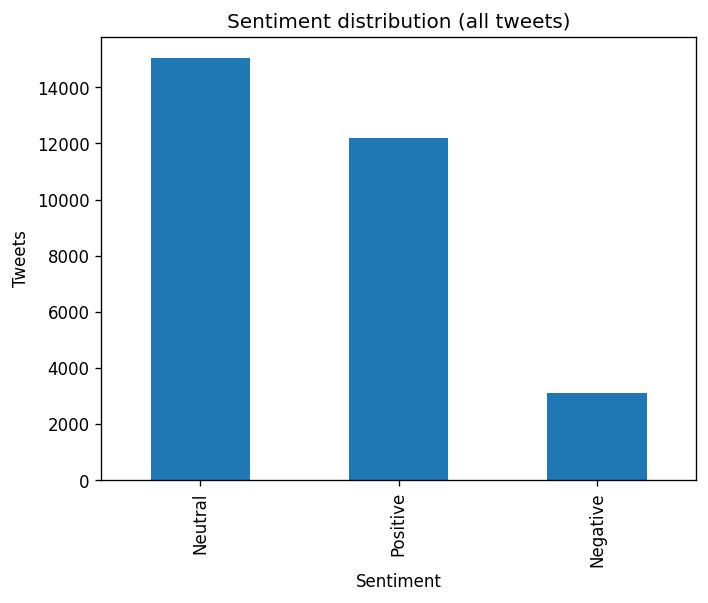

In [19]:
# Overall distribution
counts = df['sent_label'].value_counts()
print(counts)

counts.plot(kind='bar')
plt.title('Sentiment distribution (all tweets)')
plt.xlabel('Sentiment')
plt.ylabel('Tweets')
plt.show()


In [24]:
# Sentiment by party
party_summary = (
    df.groupby('party', dropna=False)
      .agg(
          n=('tweet_id','size'),
          avg_sent=('sent_score_prob','mean'),
          pos_rate=('sent_label', lambda s: (s=='Positive').mean()),
          neg_rate=('sent_label', lambda s: (s=='Negative').mean()),
          avg_conf=('sent_conf','mean')
      )
      .sort_values('avg_sent', ascending=False)
)

display(party_summary)


,n,avg_sent,pos_rate,neg_rate,avg_conf
party,,,,,
Republican,12622,0.398861,0.464665,0.062589,0.798857
Democratic,17738,0.234149,0.356917,0.130567,0.772527


,month,avg_sent,n
0,2020-05,0.305325,6380
1,2020-06,0.268688,5259
2,2020-07,0.255001,4798
3,2020-08,0.308948,4697
4,2020-09,0.359637,4406
5,2020-10,0.325220,4820


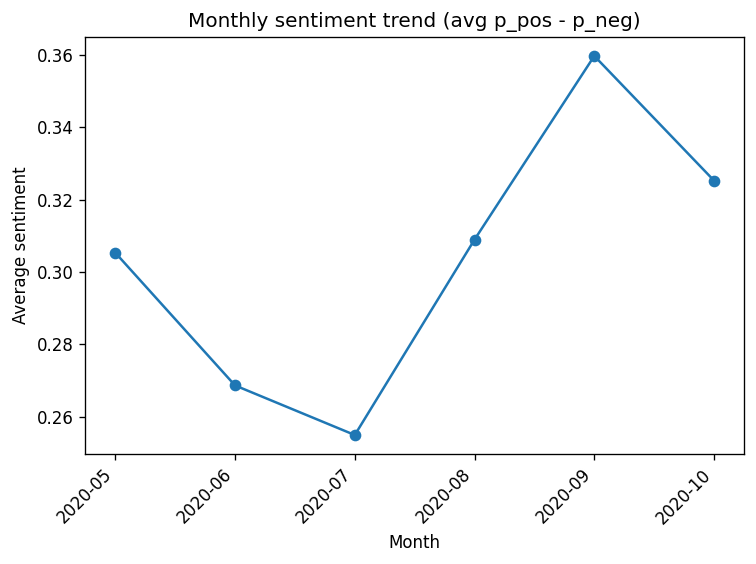

In [25]:
# Monthly trend
trend = (
    df.groupby('month')
      .agg(avg_sent=('sent_score_prob','mean'), n=('tweet_id','size'))
      .reset_index()
)

display(trend)

plt.plot(trend['month'], trend['avg_sent'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Monthly sentiment trend (avg p_pos - p_neg)')
plt.xlabel('Month')
plt.ylabel('Average sentiment')
plt.tight_layout()
plt.show()


### 9. Engagement vs sentiment (business relevance)


corr(sentiment, log_likes) = 0.074
corr(sentiment, log_retweets) = 0.001
corr(sentiment, log_replies) = 0.028


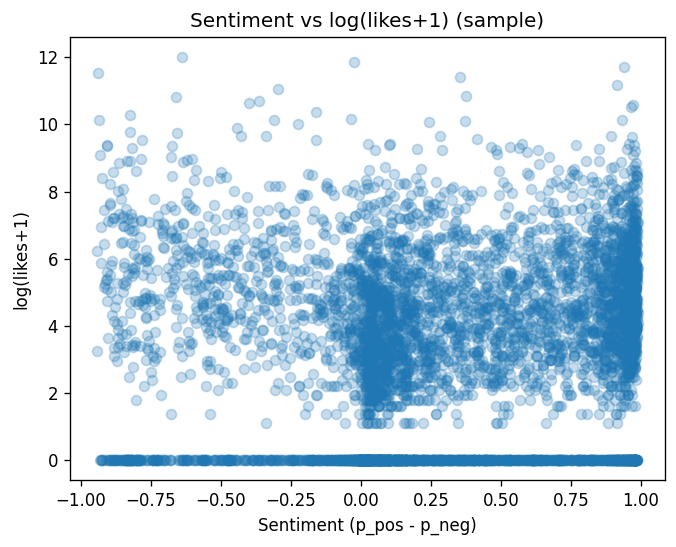

In [26]:
# Heavy-tailed engagement => log-transform
for col in ['likes','retweets','replies']:
    df[f'log_{col}'] = np.log1p(df[col])

# Correlations (simple)
eng_cols = ['log_likes','log_retweets','log_replies']
for col in eng_cols:
    corr = np.corrcoef(df['sent_score_prob'], df[col])[0,1]
    print(f'corr(sentiment, {col}) = {corr:.3f}')

# Scatter plot (sample for visibility)
sample = df.sample(n=min(5000, len(df)), random_state=42)
plt.scatter(sample['sent_score_prob'], sample['log_likes'], alpha=0.25)
plt.title('Sentiment vs log(likes+1) (sample)')
plt.xlabel('Sentiment (p_pos - p_neg)')
plt.ylabel('log(likes+1)')
plt.show()


### 10. Correctness check: manual evaluation on a sample


In [39]:
# # Export a stratified sample for manual labeling
# # You can label ~200 tweets (human_label column) in Excel/Sheets and re-import.

# N_PER_CLASS = 70  # ~210 total
# sample_df = (
#     df.groupby('sent_label', group_keys=False)
#       .apply(lambda x: x.sample(n=min(N_PER_CLASS, len(x)), random_state=42))
#       .loc[:, ['tweet_id','time','name','party','state','text','sent_label','sent_conf']]
#       .copy()
# )

# sample_df['human_label'] = ''  # fill with Negative/Neutral/Positive
# LABEL_PATH = '/Users/majid/Documents/3-third semester/text mining /manual_label_sample.csv'
# sample_df.to_csv(LABEL_PATH, index=False)
# print('Saved for labeling:', LABEL_PATH)

# display(sample_df.head(5))


In [38]:
# # After you label the file, load it and compute evaluation metrics
# # Make sure human_label has values: Negative / Neutral / Positive

# from sklearn.metrics import classification_report, confusion_matrix

# LABELED_PATH = '/Users/majid/Documents/3-third semester/text mining /manual_label_sample.csv'  # <-- rename your labeled file to this OR change path

# try:
#     labeled = pd.read_csv(LABELED_PATH)
#     # labeled = labeled.dropna(subset=['human_label'])

#     y_true = labeled['human_label'].astype(str)
#     y_pred = labeled['sent_label'].astype(str)

#     print(classification_report(y_true, y_pred, digits=3))
#     cm = confusion_matrix(y_true, y_pred, labels=['Negative','Neutral','Positive'])
#     print('Confusion matrix rows=true, cols=pred')
#     print(pd.DataFrame(cm, index=['Neg','Neu','Pos'], columns=['Neg','Neu','Pos']))

# except FileNotFoundError:
#     print('Label file not found yet. Please label and save:', LABELED_PATH)


### 11. Statistical test: difference in sentiment between parties


In [36]:
# Parties in your data:
# ['Republican', 'Democratic']

if set(["Democratic", "Republican"]).issubset(set(parties)):
    a = df.loc[df["party"] == "Democratic", "sent_score_prob"].dropna()
    b = df.loc[df["party"] == "Republican", "sent_score_prob"].dropna()
    obs, p = permutation_test_mean_diff(a, b)
    print("Mean(Democratic) - Mean(Republican) =", round(obs, 4), "p=", round(p, 4))
else:
    print("Dataset does not contain both Democratic and Republican labels.")


Mean(Democratic) - Mean(Republican) = -0.1647 p= 0.0002


A permutation test comparing mean sentiment scores (p_pos − p_neg) between parties found a significant difference: Democratic tweets had lower average sentiment than Republican tweets (mean difference = −0.1647, p = 0.0002)

>This does not prove causality (party → sentiment). The difference might be explained by:
>- different topics during May–Oct 2020 (e.g., COVID, protests, disasters),
>- different communication styles,
>- different tweeting frequency / accounts included,
>- model limitations (sarcasm, political language).

### Most positive/negative senators  (with enough tweets)
Method: group by name (and party/state), compute mean sent_score_prob, filter to senators with n >= 30 (or 50).

In [40]:
# Most positive/negative senators (require enough tweets)
by_senator = (
    df.groupby(["name","party","state"], dropna=False)
      .agg(n=("tweet_id","size"),
           avg_sent=("sent_score_prob","mean"),
           avg_conf=("sent_conf","mean"))
      .query("n >= 30")
      .sort_values("avg_sent", ascending=False)
)

display(by_senator.head(10))   # most positive
display(by_senator.tail(10))   # most negative


,,,n,avg_sent,avg_conf
name,party,state,,,
Kim Reynolds,Republican,IA,77,0.803547,0.894994
Kevin Stitt,Republican,OK,427,0.611198,0.828062
Doug Burgum,Republican,ND,262,0.571702,0.819933
Brad Little,Republican,ID,240,0.559352,0.798882
Kay Ivey,Republican,AL,524,0.542428,0.824145
Henry McMaster,Republican,SC,182,0.540925,0.810510
Doug Ducey,Republican,AZ,1323,0.537630,0.811951
Bill Lee,Republican,TN,622,0.525599,0.799277
Brian Kemp,Republican,GA,305,0.524236,0.789126


,,,n,avg_sent,avg_conf
name,party,state,,,
Roy Cooper,Democratic,NC,948,0.198998,0.749559
David Ige,Democratic,HI,468,0.196957,0.788809
Tom Wolf,Democratic,PA,863,0.196000,0.744977
Phil Murphy,Democratic,NJ,3340,0.191452,0.780864
John Bel Edwards,Democratic,LA,1142,0.190360,0.774230
Ned Lamont,Democratic,CT,952,0.175482,0.802292
Jay Inslee,Democratic,WA,640,0.159581,0.779432
Mike DeWine,Republican,OH,2251,0.123884,0.774843
Gavin Newsom,Democratic,CA,497,0.103166,0.739707


### Confidence by party and by label
Method: compare avg_conf by party and/or by sent_label.


In [41]:
# Confidence by party and by label
conf_by_party = df.groupby("party").agg(avg_conf=("sent_conf","mean"), n=("tweet_id","size"))
conf_by_label = df.groupby("sent_label").agg(avg_conf=("sent_conf","mean"), n=("tweet_id","size"))

display(conf_by_party)
display(conf_by_label)


,avg_conf,n
party,,
Democratic,0.772527,17738
Republican,0.798857,12622


,avg_conf,n
sent_label,,
Negative,0.714617,3106
Neutral,0.761079,15058
Positive,0.828660,12196


In [42]:
# Show examples per class
for lab in ["Negative","Neutral","Positive"]:
    print("\n=== Examples:", lab, "===\n")
    display(df[df["sent_label"]==lab][["text","sent_conf"]].sample(5, random_state=1))

# Show the most uncertain predictions
display(df.sort_values("sent_conf")[["text","sent_label","sent_conf"]].head(10))



=== Examples: Negative ===



,text,sent_conf
7290,"#COVID19 is highly contagious, but we don’t kn...",0.748148
16139,#COVID19 UPDATE: We have 423 new positive #COV...,0.751981
21687,"From Joe’s Brewery to Raw Fitness, Oishi Hibac...",0.552443
11980,I don’t share these stories to make anyone fee...,0.845809
2197,This will deprive states of one of the most ef...,0.841358



=== Examples: Neutral ===



,text,sent_conf
7819,"This week, the City of Richmond, Accomack Coun...",0.888929
11274,"ICYMI: Read this column by April Holman, Execu...",0.893506
23575,"Based on the data & requests from \n@oksde\n, ...",0.751652
26267,Gov. Edwards will provide an update on Louisia...,0.959702
26644,"When you wear a mask, you protect others. When...",0.628739



=== Examples: Positive ===



,text,sent_conf
2532,Many Kentuckians look out their windows each n...,0.943858
26171,Donna and I ask that you join us in lifting up...,0.524901
3870,"Once completed, this facility will provide stu...",0.740641
23714,#OklaProud,0.951422
21112,I’ve been inspired by peaceful #BlackLivesMatt...,0.891431


,text,sent_label,sent_conf
21965,Unprecended tragedy is testing our nation. But...,Negative,0.346394
24944,South Carolina is blessed with the most beauti...,Neutral,0.352123
26303,"Today, we remember the survivors and thousands...",Neutral,0.357514
20431,Sad to hear of the passing of Former Senator C...,Neutral,0.367872
5920,"September 11, 2001 will forever be marked as o...",Positive,0.368870
16113,Deeply saddened by the passing of Vincent Hyne...,Positive,0.371325
6051,Our country has lost one of its most beloved C...,Neutral,0.374444
16858,Today marks 100 days since the first case of #...,Positive,0.375755
16105,"Saddened by the passing of Gordon C. Lampitt, ...",Negative,0.377379
18870,Having to finish the school year this way brea...,Neutral,0.377426


### Qualitative check (examples + low-confidence tweets)

To evaluate the model quickly, I looked at a few random tweets from each predicted class and also the tweets with the **lowest confidence**.

* The **Negative** examples are mostly COVID warnings/updates and critical statements, which fits negative tone.
* The **Neutral** examples are mainly announcements and informational posts, so neutral is reasonable.
* The **Positive** examples include supportive or proud messages (like short slogans/hashtags), so positive also makes sense.

For the **lowest-confidence** tweets (confidence around 0.35–0.38), many are about **tragedies, memorial days, or condolences**. These tweets often mix sad topics with respectful/positive words, so the model becomes unsure between negative/neutral/positive. This shows a limitation: sentiment is harder to detect when the text has **mixed emotions**.

### What I conclude from this check
Overall, this step does not measure real accuracy, but it helps me to understand the model behavior. The predictions look reasonable for typical tweets, but the model becomes less confident for sensitive topics like memorials, disasters, and condolences. Therefore, in my analysis, I should interpret results as model-based sentiment estimates, and I should be careful when tweets contain mixed emotions or formal language.

### 12. Conclusions
---

## RQ1: How does sentiment distribution differ by party?

Based on the results, I can see a clear difference between parties. In general, **Republican tweets are more positive** than **Democratic tweets**.

The average sentiment score (which is `p_pos - p_neg`) is **0.3989 for Republican** and **0.2341 for Democratic**, so Republicans are more positive on average. Also, the **positive rate** is higher for Republicans (about **46.5%**) compared to Democrats (about **35.7%**). On the other side, Democrats have more negative tweets: **13.1% negative** for Democrats compared to only **6.3% negative** for Republicans.

Also, the permutation test shows the difference is statistically significant: the mean difference is **−0.1647** (Democratic − Republican) and the p-value is **0.0002**. This means it is very unlikely that this difference happened by random chance. So we can say party sentiment is different in this dataset.

---

## RQ2: Does sentiment shift over time (monthly trend, key periods)?

Yes, sentiment changes over time. When I look at the monthly trend, sentiment is **decreasing from May to July**, and then it is **increasing strongly from July to September**.

The lowest month is **July (0.2550)**. After that, the sentiment goes up again in **August (0.3089)** and reaches the highest point in **September (0.3596)**. In **October**, sentiment is still positive but it decreases a little to **0.3252**.

So the key point is that sentiment becomes more negative until July, and after July it becomes more positive, especially in September.

---

## RQ3: Are more positive/negative tweets associated with higher engagement?

From the correlation results, the relationship between sentiment and engagement is **very weak**.

For likes, the correlation is **0.074**, which is positive but very small. For retweets, the correlation is **0.001**, which is basically no relationship. For replies, it is **0.028**, also very small.

So I can say that **more positive tweets may get slightly more likes**, but overall sentiment does not strongly explain engagement. The scatter plot also shows the points are very spread out, so engagement can be high or low for any sentiment value. This suggests that other factors (like topic, senator popularity, or current events) probably affect engagement more than sentiment.

---

## RQ4: Which senators (accounts) have the most positive vs most negative average sentiment?

To answer this question, I grouped tweets by **account (name)** and calculated the **average sentiment score** (`avg_sent = mean(p_pos − p_neg)`). I also required a minimum number of tweets (n) so that the result is not based on only a few tweets.

### Most positive accounts (top examples)

From the results, the accounts with the **highest average sentiment** are mostly Republican, for example:

* **Kim Reynolds (Republican, IA)**: avg_sent = **0.8035**, n = 77
* **Kevin Stitt (Republican, OK)**: avg_sent = **0.6112**, n = 427
* **Doug Burgum (Republican, ND)**: avg_sent = **0.5717**, n = 262
* **Brad Little (Republican, ID)**: avg_sent = **0.5594**, n = 240
* **Kay Ivey (Republican, AL)**: avg_sent = **0.5424**, n = 524

This means these accounts tend to publish tweets where the model gives higher probability to **positive sentiment than negative sentiment**, so their average tone is more positive.

### Most negative / least positive accounts (bottom examples)

In the “lowest sentiment” list, the accounts have much lower average sentiment scores (still positive overall, but clearly lower compared to the top group). Examples are:

* **Michelle Lujan Grisham (Democratic, NM)**: avg_sent = **0.0730**, n = 847
* **Gavin Newsom (Democratic, CA)**: avg_sent = **0.1032**, n = 497
* **Mike DeWine (Republican, OH)**: avg_sent = **0.1239**, n = 2251
* **Jay Inslee (Democratic, WA)**: avg_sent = **0.1596**, n = 640
* **Ned Lamont (Democratic, CT)**: avg_sent = **0.1755**, n = 952

So, overall, the “most positive” group contains mostly Republican accounts, while the “least positive” group contains mostly Democratic accounts (with one Republican also appearing). This pattern is consistent with my earlier party-level result.

**Important note:** These results do not mean a politician is personally positive or negative; it only reflects the tone of tweet text in this time period, and it can also be influenced by topics (for example COVID warnings can look negative in sentiment).

---

## RQ5: Does model confidence change by party or by sentiment class?

Yes, based on the averages, the model confidence is not the same for all groups.

### Confidence by party

* **Republican avg_conf = 0.7989** (n = 12622)
* **Democratic avg_conf = 0.7725** (n = 17738)

So the model is **slightly more confident on Republican tweets** than on Democratic tweets. The difference is not huge, but it is consistent.

One possible interpretation is that the language in Republican tweets (in this dataset) may be more aligned with patterns the model learned for sentiment, or the tweets may use more clearly positive/negative expressions.

### Confidence by sentiment class

Here the difference is stronger:

* **Positive:** avg_conf = **0.8287** (highest confidence)
* **Neutral:** avg_conf = **0.7611**
* **Negative:** avg_conf = **0.7146** (lowest confidence)

This means the model is most confident when it predicts **Positive**, and least confident when it predicts **Negative**. In practice, negative tweets can be more complex (for example warnings, criticism, sarcasm, disaster news), which might make the model less certain.

**Conclusion for RQ5:** Confidence changes by both party and sentiment class, but the strongest pattern is that **positive predictions have the highest confidence**, while **negative predictions have the lowest confidence**.





## Comparison of methods (overall)

In my project I used three sentiment approaches:

1. **Transformer (RoBERTa Twitter model)** – context-aware, gives probabilities for Negative/Neutral/Positive.
2. **VADER (dictionary / rule-based)** – counts sentiment words and rules, simple baseline.
3. **TF-IDF + Logistic Regression (supervised + tuned)** – classical ML model trained with pseudo-labels.

Even though the numbers are not identical, all methods show the **same main story**: **Republican tweets are more positive on average than Democratic tweets**, and sentiment is highest around **September**.







### Comparison table (Transformer vs VADER vs TF-IDF+LogReg)

| Method                           | Type                                                           | Labels distribution (overall)                                             | Party avg sentiment (Rep vs Dem) | Party pos rate (Rep vs Dem) | Party neg rate (Rep vs Dem) | Monthly pattern                                                 | Engagement relationship                                 |
| -------------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------- | -------------------------------- | --------------------------- | --------------------------- | --------------------------------------------------------------- | ------------------------------------------------------- |
| **Transformer (RoBERTa)**        | Supervised Transformer (pretrained)                            | Neutral highest; Positive second; Negative lowest                         | **0.399 vs 0.234**               | **0.465 vs 0.357**          | **0.063 vs 0.131**          | Lowest around **July**, peak **September**, slight drop October | weak: likes **0.074**, RT **0.001**, replies **0.028**  |
| **VADER**                        | Dictionary / rule-based                                        | Positive very high (19,632); Neutral 6,082; Negative 4,776                | **0.368 vs 0.298**               | **0.674 vs 0.622**          | **0.129 vs 0.176**          | More stable; peak **September**                                 | weak: likes **0.057**, RT **0.015**, replies **0.026**  |
| **TF-IDF + Logistic Regression + Grid search** | Supervised ML (tuned) *(trained on Transformer pseudo-labels)* | same as training labels (Neutral 15,058; Positive 12,196; Negative 3,106) | **0.369 vs 0.191**               | **0.465 vs 0.359**          | **0.065 vs 0.138**          | Low **June/July**, peak **September**, drop October             | weak: likes **0.065**, RT **−0.007**, replies **0.018** |


### Important to note:
> “TF-IDF + Logistic Regression was trained using Transformer pseudo-labels, so its evaluation shows agreement with the Transformer model rather than true human sentiment accuracy.”




## Short conclusion 

>Overall, **Transformer and TF-IDF+LR are more consistent with each other**, because LR was trained using Transformer pseudo-labels. **VADER gives more Positive sentiment**, which is expected since it is lexicon-based and less context-aware. Despite these differences, all methods support the same main findings: Republicans tweets are more positive than Democrats, sentiment peaks in September, and engagement has only weak connection with sentiment.
